<a href="https://colab.research.google.com/github/1040mxg/5334project/blob/main/5334proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

[Blog homepage](https://1040mxg.github.io/blog/) || [View Report on Github](https://github.com/1040mxg/5334project/blob/main/5334proj.ipynb) || [Github Repo](https://github.com/1040mxg/5334project)

This project will build a classifier to detect specific media bias, and find the probability that a given piece of written news is by, or influenced by, Chinese state-sponsored media. 

A prevalent issue among mainland Chinese diaspora is the spread of sensationalist “fake news” and propaganda through various websites and popular messaging apps. These news sources are essential parts of life and often the only source of news for older Chinese immigrants, but strict guidelines set forth by the ruling Chinese government (“CCP”) authority restricts what topics may be covered and how, so as to hide calls for reform or exposure of human rights abuses that may subvert government authority. For these reasons, there is a general distrust among Chinese diaspora of state-sanctioned media such as Xinhua or People’s Daily, but very rarely does this same caution extend to English-language sources. This creates the issue that I seek to address: English-language versions of major CCP media exist, both branded and unbranded. I seek to create a classifier that can detect possible state media influence on unbranded (ie. not connected to any large or known news source) English-language articles, by seeing how similar the unknown text is to the writing styles of CCP-sanction media. In this way, the hope is that effects of CCP propaganda on overseas diaspora can be highlighted and reduced.


# Method

The datasets used were collected by me over December of 2020. They consist of 6,000 to 7,000 tweets scraped from the official Xinhua News Agency Twitter and a little under 1,000 tweets from NPR News. In addition, about 20 pages of headlines and articles totalling over 110,000 words were scraped from the official Xinhua site.

**Xinhua News Agency** is China's largest state-run media, and one notorious for spreading propaganda and censoring information critical of the ruling government. This strong association is why it was chosen for this project.

**NPR**, or National Public Radio, is the closest the United States has to a national, state-run news source a la the BBC. With its relatively unbiased and open reporting, it has been chosen as a point of comparison against Xinhua.

 This project makes use of the Natural Language Toolkit (NLTK) to help process text. 

In [ ]:
pip install --user -U nltk

# Preprocessing

First, I import the desired files and load necessary libraries. Here, I've imported the NLTK corpus of English-language stopwords (common articles and prepositions such as "the", "an", "there" that are largely irrelevant in data mining).

In [ ]:
###import necessary libaries
import nltk
from nltk.corpus import words, stopwords
nltk.download('stopwords')
nltk.download('words')
from nltk import ngrams
from collections import Counter

stopwords = stopwords.words('english')
words = words.words()

I combine all the data from each source into one here, but the data can also be analysed by topic.

In [392]:
filenames1 = ['tweets_xh_hk.txt', 'tweets_xh_taiwan.txt', 'tweets_xh_xinjiang.txt']
filenames2 = ['tweets_npr_hk.txt', 'tweets_npr_tw.txt', 'tweets_npr_xinjiang.txt']

with open('tweets_xh_all.txt', 'w') as outfile:
    for names in filenames1:
        with open(names) as infile:
            outfile.write(infile.read())

with open('tweets_npr_all.txt', 'w') as outfile:
    for names in filenames2:
        with open(names) as infile:
            outfile.write(infile.read())

X = []
y = []

Then I load in the data from NPR and Xinhua News, label them, and combine them into one dataset.

In [393]:
##import data files and print some basic stats
###data files will default to combined data unless specified

def loadData(file1 = "tweets_xh_all.txt", file2="tweets_npr_all.txt"):
#first, load the XH and NPR data individually
  xhData = []
  nprData = []
  with open(file1, 'r') as f:
    for row in f:
      xhData.append(row+'0')
  with open(file2, 'r') as f:
    for row in f:
      nprData.append(row+'1')
  print("XH items:", len(xhData))
  print("NPR items:", len(nprData))


#compile the NPR and XH files into one
  data = []
  for i in range(len(xhData)):
    if len(xhData[i]) > 25:
      data.append([xhData[i], '0'])
  for i in range(len(nprData)):
    if len(nprData[i]) > 25:
      data.append([nprData[i], '1'])
  print("Total data items:", len(data))
  return data

data = loadData()

XH items: 6299
NPR items: 698
Total data items: 6710


Next, I shuffle the data and split it into training, dev, and test sets.

In [394]:
import random

random.seed(1)
random.shuffle(data)
dataLen = len(data)
print(dataLen)

###manual division
testLen = int(.2*dataLen)
devLen = int(.2*(dataLen - testLen))
trainLen = dataLen - testLen - devLen

train = []
dev = []
test =[]
for i in range(trainLen):
  train.append(data[i])

for i in range(trainLen, trainLen+devLen):
  dev.append(data[i])

for i in range(dataLen-testLen, dataLen):
  test.append(data[i])

print("Train Data: %d items" %(len(train)))
print("Dev Data: %d items" %(len(dev)))
print("Test Data: %d items" %(len(test)))

6710
Train Data: 4295 items
Dev Data: 1073 items
Test Data: 1342 items


# Training: Naive Bayes

I will first try to buld a classifier based on Naive Bayes.

**Naive Bayes** is a simple, fast, and accurate algorithm that works particularly well with natural language processing (NLP), or text classification. In my tests, I used the **Multinomial Naive Bayes** algorithm. It works by taking advantage of probability theory and Bayes' Theorem to classify text. For each piece of input text, the probability of each possible class is calculated and the final classification made based on highest probability.

The training set is split into two lists based on source.

In [395]:
def split(data):
  nprStr = []
  xhStr = []
  for i in range(len(data)):
    if data[i][-1] == '1':
      nprStr.append(data[i][0])
    elif data[i][-1] == '0':
      xhStr.append(data[i][0])
  return nprStr, xhStr

def printSample(nprStr, xhStr):
  print("Xinhua Tweets: %d items" %(len(xhStr)))
  print("---------------Sample---------------")
  for i in range(5):
    if(len(xhStr[i])>80):
      print("%s..." %xhStr[i][0:80])
    else:
      print(xhStr[i], end='')
  print("\n")
  print("NPR Tweets: %d items" %(len(nprStr)))
  print("---------------Sample---------------")
  for i in range(5):
    if(len(nprStr[i])>80):
      print("%s..." %nprStr[i][0:80])
    else:
      print(nprStr[i], end='')

nprStr, xhStr = split(train)
printSample(nprStr, xhStr)

Xinhua Tweets: 3985 items
---------------Sample---------------
Ethnic groups in Xinjiang are part of Chinese nation: white paper xhne.ws/znLOe ...
3. Panda recognition tech xhne.ws/oKuA9 https://t.co/gjVitH2EFX"
0Hong Kong immigration director vows to attract more talents xhne.ws/Zs4nP (Xinhu...
Findings at the caves, dubbed "gateway to heaven", will fill the gap of Xinjiang...
300-km-long desert road, crossing China's largest desert Taklimakan nicknamed "S...


NPR Tweets: 310 items
---------------Sample---------------
The association has been ordered to pay the equivalent of $15,000 and was given ...
A Hong Kong district court has found nine activists guilty of public nuisance cr...
Hong Kong has 110 McDonalds outlets that are open 24 hours, and they are relucta...
Beijing Brushes Aside Hong Kongs Rejection Of Electoral Reform n.pr/1Bm1nz0
1After bringing the number of local coronavirus cases down to zero, Hong Kong is ...


The data lists are further processed into dictionaries of vocabularies. 
Each line in the lists was split into individual words and added to a temporary dictionary. This temporary dictionary was then trimmed to include only words that do not appear in the list of stopwords.

In [396]:
import re

#trainset vocab list + split into npr/xh
def splitWord(strings, tempDict):
  words = 0
  for line in strings:
    line = line.lower()
    temp = re.findall(r'\w+', line)
    for word in temp:
      words+=1
      if word in tempDict:
        tempDict[word] +=1
      else:
        tempDict[word] = 1

def trim(strings, tempDict):
  keys = list(tempDict.keys())
  vals = list(tempDict.values())
  newDict = dict()
  count = 0
  for i in range(len(vals)):
    k = keys[i]
    if k not in stopwords and k in words:
      newDict[k] = vals[i]
      count+=vals[i]
  return newDict, count

def makeVocab(strings):
  tempDict = dict()
  splitWord(strings, tempDict)
  newDict, count = trim(strings, tempDict)
  return newDict, count

print("---------------Xinhua Word List---------------")
xhVocab, xhCount = makeVocab(xhStr)
print("Words After Trimming: ", xhCount)
print("Unique Words: %d\n" %len(xhVocab))

print("---------------NPR Word List---------------")
nprVocab, nprCount = makeVocab(nprStr)
print("Words After Trimming: ", nprCount)
print("Unique Words: %d\n" %len(nprVocab))

print("---------------All Words---------------")
allVocab = {**nprVocab, **xhVocab}
allCount = nprCount+xhCount
print("Total Word Count: ", allCount)
print("Unique Words: ", len(allVocab))

# print("Positive:", nprVocab)
# print("Negative:", xhVocab)
# print("All:", allVocab)  

---------------Xinhua Word List---------------
Words After Trimming:  32761
Unique Words: 4532

---------------NPR Word List---------------
Words After Trimming:  2541
Unique Words: 1046

---------------All Words---------------
Total Word Count:  35302
Unique Words:  4759


P(xh) and P(npr) were calculated by dividing the count of each by the total (trimmed) word count.

Individual P(word|author) were calculated using (#word in class)/(#total word count in sentiment class). A general P(word) was also calculated using (#word/#total word count). All three were stored in new dictionaries.

In addition, one major issue that Naive Bayes faces in text classification is missing data. When a word does not appear in a class, making P(word|class) = 0, that probability gets multiplied out to all the other probabilities in determining P(class), making P(class) = 0.

Laplace smoothing is a method of combatting this issue. The process is:
1.   Add 1 to every count so P(word|class) will always > 0.
2.   Balance this by adding the number of possible words to the divisor so the result will never < 1.


In [397]:
#get probabilities for P(npr), P(xh) based on trimmed word counts
allCount = nprCount+xhCount
print("---------------Probabilities---------------")
print("P(npr) = %d/%d = %.5f" %(nprCount, allCount, nprCount/allCount))
print("P(xh) = %d/%d = %.5f\n" %(xhCount, allCount, xhCount/allCount))

##laplace smoothing
nprCount+=len(allVocab)
xhCount+=len(allVocab)
allCount = nprCount+xhCount
#for test words of P=0
noNPR = 1/nprCount
noXH = 1/xhCount

#get individual P(word|class) and store in dictionary
def getProbs(Dict, PCount):
  keys = list(Dict.keys())
  vals = list(Dict.values())
  newDict = dict()
  for i in range(len(vals)):
    k = keys[i]
    p = vals[i]/PCount
    newDict[k] = p
  return newDict

nprProb = getProbs(nprVocab, nprCount)
xhProb = getProbs(xhVocab, xhCount)
allProb = getProbs(allVocab, allCount)

print("---------------P(word) Sample---------------")
print({k: allProb[k] for k in list(allProb)[:5]}, "\n")

print("---------------P(word|npr) Sample---------------")
print({k: nprProb[k] for k in list(nprProb)[:5]}, "\n")

print("---------------P(word|xh) Sample---------------")
print({k: xhProb[k] for k in list(xhProb)[:5]})

---------------Probabilities---------------
P(npr) = 2541/35302 = 0.07198
P(xh) = 32761/35302 = 0.92802

---------------P(word) Sample---------------
{'association': 0.00015618027666220436, 'ordered': 2.2311468094600625e-05, 'pay': 2.2311468094600625e-05, 'equivalent': 2.2311468094600625e-05, 'given': 0.00015618027666220436} 

---------------P(word|npr) Sample---------------
{'association': 0.000273972602739726, 'ordered': 0.000136986301369863, 'pay': 0.000136986301369863, 'equivalent': 0.000136986301369863, 'given': 0.00041095890410958907} 

---------------P(word|xh) Sample---------------
{'ethnic': 0.0010394456289978678, 'part': 0.0008528784648187633, 'nation': 0.0002398720682302772, 'white': 0.0013326226012793177, 'paper': 0.0012260127931769723}


# Testing Model with Dev Set

First, just applying the algorithm directing to the dev set:


In [398]:
def splitTrim(line):
  words = []
  temp = re.findall(r'\w+', line)
  for i in temp:
    if len(i)>2:
      words.append(i)
  #print(words)
  return words

#with Laplace smoothing
def naiveBayes(line, vocab0, vocab1):
  words = splitTrim(line)
  p_npr = 1
  p_xh = 1
  for word in words:
    if word in vocab1:
      p_npr = nprProb[word]*p_npr
    else:
      p_npr = p_npr*noNPR
    if word in vocab0:
      p_xh = xhProb[word]*p_xh
    else:
      p_xh = p_xh*noXH
  if p_npr < p_xh:
    pred = 0
  elif p_npr > p_xh:
    pred = 1
  else:
    return 2
  return pred

def predict(data, algorithm=naiveBayes, vocab0=xhVocab, vocab1=nprVocab):
  correct = 0
  total = 0
  for line in data:
    actual = int(line[-1])
    pred = algorithm(line[0], vocab0, vocab1)
    #print("Test: ",pred, actual)
    if pred == actual:
      correct+=1
      total+=1
    else:
      total+=1
  acc = correct/total
  return acc, correct, total

acc, correct, total = predict(dev)
acc = acc*100
print("Accuracy: %.3f " %acc, "%")

X.append("Dev")
y.append(acc)

Accuracy: 9.413  %


**Five-Fold Cross Validation**

This tests the algorithm using cross validation. The process is as follows:
1.   Split the data into 5 groups
2.   For each group, use it as a test set with the remaining groups as training sets
3.   Fit a model on the training set and evaluate on the test set
4.   Repeat the above until all samples have had a turn as a test set
5.   Find the mean accuracy

In [399]:
#split dataset into 5 folds
def crossValsplit(dataset):
  folds = 5
  data_split = list()
  data_copy = list(dataset)
  fold_size = int(len(dataset)/folds)
  for i in range(folds):
    fold = list()
    while len(fold) < fold_size:
      index = randrange(len(data_copy))
      fold.append(data_copy.pop(index))
    data_split.append(fold)
  return data_split

def evaluate(data):
  folds = crossValsplit(data)
  scores = list()
  for fold in folds:
    train = list(folds)
    train.remove(fold)
    train = sum(train, [])
    test = list()
    for row in fold:
      test.append(row)
    #create new dictionaries based on fold
    x_nprStr, x_xhStr = split(train)
    x_nprVocab, x_nprCount = makeVocab(x_nprStr)
    x_xhVocab, x_xhCount = makeVocab(x_xhStr)
    x_allVocab = {**x_nprVocab, **x_xhVocab}
    x_allCount = x_nprCount+x_xhCount
    x_nprProb = getProbs(x_nprVocab, x_nprCount)
    x_xhProb = getProbs(x_xhVocab, x_xhCount)
    x_allProb = getProbs(x_allVocab, x_allCount)
    acc, correct, total = predict(test)
    acc = acc*100
    scores.append(acc)
  print("Scores: %s" %scores)
  mean = sum(scores)/float(len(scores))
  print('Mean Accuracy: %.3f%%' %mean)
    
mean = evaluate(dev)

X.append("X-valid")
y.append(mean)

Scores: [9.813084112149532, 7.476635514018691, 14.018691588785046, 7.943925233644859, 7.943925233644859]
Mean Accuracy: 9.439%


Even with Laplace smoothing, the algorithm is not very accurate, on either the cross-validation or applied directly to the dev data. 


# Experiments

I will start approaching this problem from a few different directions.

First, instead of a pure "yes/no" comparison, I want to see how the classifier and training data do in predicting P(class).

Loading a new dataset of only Xinhua data and leaving it unlabelled.

In [400]:
newData = []

with open("tweets_xh_hk.txt", 'r') as f:
    for row in f:
      newData.append(row)

for i in range(5):
  print(newData[i][0:80], "...")

The 2020 policy address delivered by HKSAR Chief Executive Carrie Lam has won st ...
The national security law in China's Hong Kong has been remarkably effective in  ...
Hong Kong embraces greater development opportunities with new policy address unv ...
HKSAR Chief Executive Carrie Lam delivered the 2020 policy address, highlighting ...
The central authorities will fully support Hong Kong's development in 7 aspects  ...


Adjusting the Naive Bayes method to return P(class) instead of a prediction and taking the mean probability of each class.

In [401]:
import numpy as np

#with Laplace smoothing
def naiveBayesPoss(line, vocab0, vocab1):
  words = splitTrim(line)
  #print(words)
  p_npr = 1
  p_xh = 1
  for word in words:
    if word in vocab1:
      p_npr = nprProb[word]*p_npr
    else:
      p_npr = p_npr*noNPR
    if word in vocab0:
      p_xh = xhProb[word]*p_xh
    else:
      p_xh = p_xh*noXH
  return p_npr, p_xh

def predictPoss(data, vocab0=xhVocab, vocab1=nprVocab):
  arrNPR = []
  arrXH = []
  for line in data:
    #print(line)
    predNPR, predXH = naiveBayesPoss(line, vocab0, vocab1)
    arrNPR.append(predNPR)
    arrXH.append(predXH)
    #print("Test: ",pred, actual)
  possNPR = np.mean(arrNPR)
  possXH = np.mean(arrXH)
  return possNPR, possXH

possNPR, possXH = predictPoss(newData)
print('Mean possXH: %.3f%%' %possXH)
print('Mean possNPR: %.3f%%' %possNPR)

X.append("Mean\nP(class)")
y.append(possXH)

Mean possXH: 0.002%
Mean possNPR: 0.002%


Given that the data used in the experiment above *only* came from Xinhua, the mean P(class) should have been much higher than it is, or at least higher than possNPR.

**Top Words**

Next, I will derive the top 10 words for predicting class, ie. the top 10 each of P(Positive|word) and P(Negative|word). Given that:

$P(class|word)=\frac{P(word|class)P(class)}{P(word)}$

and I already have the values for P(word), P(class), and P(word|class), this will be a simple matter of finding the top 10 values.

In [402]:
"""
Find the top ten P(class|word) for each class
"""
def topTen(classDict, classCount):
  words = []
  probs = []
  #keys = word, vals = P(word|class)
  keys = list(classDict.keys())
  vals = list(classDict.values())
  pClass = classCount/allCount
  for i in range(len(keys)):
    pWord = allProb[(keys[i])]
    p = (vals[i]*pClass)/pWord
    words.append(keys[i])
    probs.append(p)
  top = sorted(range(len(probs)), key=lambda i: probs[i])[-10:]
  topWords = []
  for i in top:
    topWords.append(words[i])
  return topWords

topNPR = topTen(nprProb, nprCount)
topXH = topTen(xhProb, xhCount)

print("Top NPR Words:")
print(topNPR)
print("\nTop XH Words:")
print(topXH)

acc, correct, total = predict(data, algorithm=naiveBayes, vocab0=topXH, vocab1=topNPR)
acc = acc*100
print("\nAccuracy, Top10 Words: %.3f%%" %acc)

X.append("Top10")
y.append(acc)

Top NPR Words:
['whose', 'enemy', 'withdraw', 'remarkably', 'shut', 'strike', 'tear', 'extradition', 'pro', 'n']

Top XH Words:
['struck', 'heart', 'migrant', 'properly', 'policeman', 'afternoon', 'bloom', 'therapy', 'low', 'battle']

Accuracy, Top10 Words: 7.481%


Changing the parameters to top 10 words only decreased accuracy.

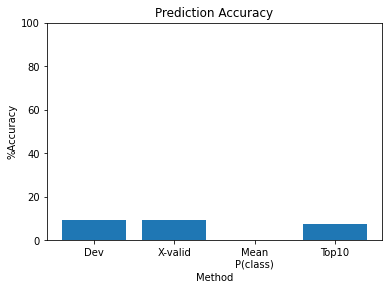

In [415]:
import matplotlib.pyplot as plt

y[1] = 9.439

plt.title("Prediction Accuracy")
plt.ylim(0,100)
plt.xlabel("Method")
plt.ylabel("%Accuracy")
plt.bar(X,y)
plt.show()

# Analysis: Naive Bayes

None of these methods are very strong. Clearly, this dataset is very different from something like a dataset of movie reviews. Even though the general idea is similar (movie reviews using "positive" and "negative" words to find sentiment), using the same methods yields very different results.

Why is this? The most likely reason is that with this dataset, the end target is finding **authorship**. Authorship is much more than expressing one kind of sentiment; it is the analysis of how **all** ideas are expressed. Even though NPR and Xinhua

# Experiments: Stylometric Methods

Given the general failure of Naive Bayes, I will now try other methods to train and test a classifier.

**Stylometry** is the application of the study of linguistic style, often used to determine authorship of unknown documents. Perhaps one of the most common applications of this in machine learning has been in determining authorship of the *Federalist Papers*. With these methods, one key difference is the consideration of how words, including those usually considered irrelevant such as prepositions and articles, are stringed together. Unlike with Naive Bayes, order and use matter, and also unlike Naive Bayes, it applies much more to this current experiment as it specifically works to identify individual authors and writing styles-- much like how a news outlet like Xinhua or NPR would have their own reporting styles, or style guides their reporters would be expected to follow.

First, creating new dictionaries with author as keys and tweets in their *entirety* as the value. This time, I will use the file hktwmaco.txt, a compilation of headlines and partial article content from the official Xinhua News web site as a test subject.

In [442]:
import nltk

tweets_by_source = dict()

def read_files_into_string(filename):
    strings = []
    with open(filename) as f:
            strings.append(f.read())
    return '\n'.join(strings)


tweets_by_source["Xinhua"] = read_files_into_string("tweets_xh_all.txt")
tweets_by_source["NPR"] = read_files_into_string("tweets_npr_all.txt")
tweets_by_source["Test"] = read_files_into_string("hktwmacao.txt")

The first test I will try is known as **Mendenhall's Characteristic Curves of Composition**, one of the first ever stylometric tests developed in the 1800s. This works by associating an author's stylistic signature with how often they used words of different lengths. That is to say, for any particular author X, if we look at something they write, we can expect to find the same general distribution of word lengths no matter where we look.

In [ ]:
nltk.download('punkt')

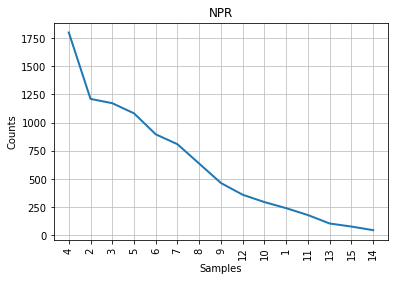

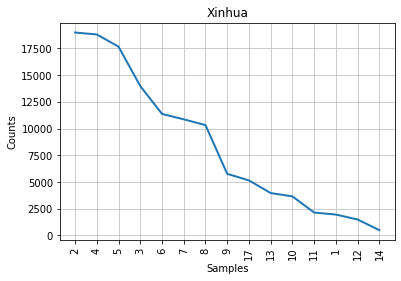

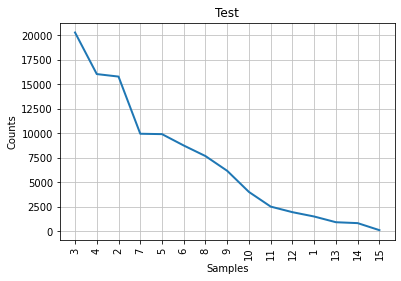

In [456]:
#compare the test text with the known sources
sources = ("NPR", "Xinhua", "Test")

#transform texts into tokens

def mendenhall(sources):
  tweets_by_source_tokens = {}
  tweets_by_source_length_distributions = {}
  for source in sources:
    tokens = nltk.word_tokenize(tweets_by_source[source])

    #take out punctuation
    tweets_by_source_tokens[source] = ([token for token in tokens
                                            if any(c.isalpha() for c in token)])

    #get distribution of word lengths, creating a frequency distribution of how many n-letter words
    #there are in that particular author's body of text
    token_lengths = [len(token) for token in tweets_by_source_tokens[source]]
    tweets_by_source_length_distributions[source] = nltk.FreqDist(token_lengths)
    tweets_by_source_length_distributions[source].plot(15,title=source)

mendenhall(sources)

In the graphs above, the x-axis represents the word length (3 letters, 5 letters, etc.) and the y-axis shows how many of each word there is in the text. The test sample *looks* most like the Xinhua sample (which would be correct), but also, this is an incredibly brute-force and blunt way by which to try to classify the text; not the most effective.

For something that is much more modern (and accurate), I will use the Delta method by Australian literary scholar John F. Burrows. This method measures the "distance" between texts, coming up with a final Delta measure of how much a given unknown text and set of known texts by any number of authors diverage from the average of all of them together. In other words, the lower a Delta measure, the more similar the text.


The Delta method works as follows:


1. Find the N most frequent words in a corpus (collection) of texts written by X number of authors.


In [458]:
sources = ("NPR", "Xinhua", "Test")

for source in sources:
    tweets_by_source_tokens[source] = (
        [tok.lower() for tok in tweets_by_source_tokens[source]])

# combine all texts except test into a single corpus
whole_corpus = []
for source in sources:
    whole_corpus += tweets_by_source_tokens[source]

# frequency distribution where N=10
whole_corpus_freq_dist = list(nltk.FreqDist(whole_corpus).most_common(30))
whole_corpus_freq_dist[ :10 ]

[('the', 13589),
 ('of', 7673),
 ('in', 6676),
 ('to', 6123),
 ('and', 6063),
 ('hong', 5275),
 ('kong', 5131),
 ('https', 4625),
 ("'s", 3886),
 ('a', 3480)]

2. For each of these N most frequent words, calculate the percentage of its appearance in each known author X's subcorpus-- for example, 5% of all the words in author A's text is the word "they". In this way, the Delta method is similar to the Naive Bayes approach.
3. Calculate the mean and standard deviation of these percentages and use them as the mean and standard deviation for each given word over the entire collection of texts.
4. For each word, calculate a Z-score representing how far from the corpus norm that word's usage is in a particular subtext, as seen in this equation, where C is the observed frequency of a particular word "i". $Z_i = \frac{C_i-\mu_i}{\delta_i}$
5. Perform this calculation for each word in all the known and unkown texts.

In [455]:
features = [word for word,freq in whole_corpus_freq_dist]
feature_freqs = {}

for source in sources:
    #dictionary of words for each source
    feature_freqs[source] = {}

    overall = len(tweets_by_source_tokens[source])

    #count of each feature in subtext
    for feature in features:
        presence = tweets_by_source_tokens[source].count(feature)
        feature_freqs[source][feature] = presence / overall

import math

corpus_features = {}

for feature in features:
    #subdictionary of each feature's mean and stdev
    corpus_features[feature] = {}

    #mean of the frequencies
    feature_average = 0
    for source in sources:
        feature_average += feature_freqs[source][feature]
    feature_average /= len(sources)
    corpus_features[feature]["Mean"] = feature_average

    #standard deviation
    feature_stdev = 0
    for source in sources:
        diff = feature_freqs[source][feature] - corpus_features[feature]["Mean"]
        feature_stdev += diff*diff
    feature_stdev /= (len(sources) - 1)
    feature_stdev = math.sqrt(feature_stdev)
    corpus_features[feature]["StdDev"] = feature_stdev

feature_zscores = {}
for source in sources:
    feature_zscores[source] = {}
    for feature in features:

        # Z-score definition = (value - mean) / stddev
        feature_val = feature_freqs[source][feature]
        feature_mean = corpus_features[feature]["Mean"]
        feature_stdev = corpus_features[feature]["StdDev"]
        feature_zscores[source][feature] = ((feature_val-feature_mean) /
                                            feature_stdev)
        
#tokenize the test case
testcase_tokens = nltk.word_tokenize(tweets_by_source["Test"])

testcase_tokens = [token.lower() for token in testcase_tokens
                   if any(c.isalpha() for c in token)]

#test case's features
overall = len(testcase_tokens)
testcase_freqs = {}
for feature in features:
    presence = testcase_tokens.count(feature)
    testcase_freqs[feature] = presence / overall

#test case's feature z-scores
print("----------Z-scores----------")
testcase_zscores = {}
for feature in features:
    feature_val = testcase_freqs[feature]
    feature_mean = corpus_features[feature]["Mean"]
    feature_stdev = corpus_features[feature]["StdDev"]
    testcase_zscores[feature] = (feature_val - feature_mean) / feature_stdev
    print("[",feature,"]:", testcase_zscores[feature])


----------Z-scores----------
[ the ]: 1.1490522290859977
[ of ]: 1.153231064747455
[ in ]: -1.0874022789189166
[ to ]: 0.5221532740284536
[ and ]: 1.1451173148793503
[ hong ]: -0.5699099928584107
[ kong ]: -0.5415745064303736
[ https ]: -0.6604798660810742
[ 's ]: 0.09102959322000043
[ a ]: -0.672383847232734
[ china ]: -0.9731768271212423
[ on ]: 0.6533646394073037
[ for ]: 1.0772247673222888
[ xinjiang ]: -0.6307490262307903
[ taiwan ]: -1.1412736838910391
[ by ]: 1.1412662661017425
[ said ]: 1.1498500357094348
[ is ]: -0.7309598461681048
[ with ]: -0.04673177804875599
[ hksar ]: 1.1172169980462643
[ that ]: 0.6472966249533051
[ as ]: 0.20228435537302505
[ from ]: -0.062294545864831546
[ has ]: -0.551672912603498
[ people ]: 0.9894204468081397
[ chinese ]: -1.1173901183818555
[ government ]: 1.1448573500536892
[ will ]: 1.0875219609530289
[ at ]: -0.6222178681958126
[ mainland ]: -0.057904627543555486


6. Calculate a delta score that is the average of the absolute values of all differences between the Z-scores of each word between the unknown text "Y" and a given author "X"'s texts. $\Delta_x = \sum_{i}^{}\frac{\left |Z_{x(i)}-Z_{y(i)}  \right |}{n}$ The lower the Delta score, the more similar the text.

In [450]:
print("--------Delta Scores--------")
for source in sources:
    delta = 0
    for feature in features:
        delta += math.fabs((testcase_zscores[feature] -
                            feature_zscores[source][feature]))
    delta /= len(features)
    print("%s:"%source, delta )

NPR: 1.3842648935840516
Xinhua: 1.1916270157432518
Test: 0.0


The test case used for the above was, in fact, the "Test" text-- therefore, its Delta score was and should be 0. After that, Xinhua News had a lower Delta score than NPR, which is correct; the test case was written by Xinhua News.

# Analysis: Stylometric Methods

There are many similarities between the Delta method algorithm that worked well above, and the Naive Bayes algorithm. Both take into account word usage and frequency, and use these frequencies in determining the similarities between texts. The key differences, in the end, is the way these results are frame. Multinomial Naive Bayes does not take into account means or standard deviations, and in the end gives a percentage based on how many predictions were entirely correct, or entirely wrong.

Delta method compares directly the differences between the unknown and known texts, and takes far more into account to create a more accurate final result.

# Contributions

As far as I have found, my project is the only of its kind, based on previous data collected by me. From my previous work, I improved on the data analysis, building and applying actual classifiers and algorithms. I optimised Naive Bayes the best I could with methods such as Laplace smoothing, and improved on existing, similar applications such as KnowBias by making use of a specific type of media. 

# References

*   Bruno Stecanella, "A practical explanation of a Naive Bayes classifier", https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/
*   Jason Brownlee, "Naive Bayes Classifier From Scratch in Python
", https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/
*   François Dominic Laramée, "Introduction to stylometry with Python", https://programminghistorian.org/en/lessons/introduction-to-stylometry-with-python

